In [ ]:
"""
自然言語と単語の分散表現

コンピューターが機械言語ではない、人間の言語を理解するにはどのようなモデル・アルゴリズムを考えればいいか
という本質的な問題を考える。まずテキストをPythonで扱えるようにする他、テキストを単語に分割・単語を単語IDに変換する処理を覚える

自然言語の難しさは、プログラミング言語と違い曖昧さ・コンテキスト・同じ文章での意味の違い等々の「柔らかさ」を
データ化することが難しいことにある。この柔らかさが、人が適当かつ迅速な思考・行動をすることを可能にしている。

言語はまず文字によって構成され、言葉の意味は単語によって構成される。自然言語をコンピューターで扱いには、
「単語の意味」を何らかの方法でデータ化する必要がある。
これまでに単語の意味を表現するには、シソーラス・カウントべース・推論べ―ス(word2vec)という手法が考案されている。
今回はカウントベース、推論ベースの手法を実装する
"""

"""
テキストデータを扱うには、まずテキストの集まりであるコーパスが必要。
コーパスにはテキストの本質である「意味」や「知識」といった、単なる文字の集まりではないデータが含まれている、と見做す
ことができる

まず、テキストをデータに変換する方法を考える
"""

In [1]:
#テキストを全て小文字に＋ピリオドを正規化する
text = "You say goodbye and I say hello."
text = text.lower()
text = text.replace(",", " ,")

print("テキスト")
print(text)

#空白で区切る
words = text.split(" ")
print("空白区切り")
print(words)

#単語をインデックスを対応させる
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

print("単語＋単語ID")
print(word_to_id)
print(id_to_word)

#文章を単語から単語のID=コーパスに変換する
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)

print("コーパス")
print(corpus)

テキスト
you say goodbye and i say hello.
空白区切り
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello.']
単語＋単語ID
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello.': 5}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello.'}
コーパス
[0 1 2 3 4 1 5]


In [2]:
"""
テキストを処理してコーパスのリスト・{単語：単語ID}の辞書データに変換する関数
"""

'\nテキストを処理してコーパスのリスト・{単語：単語ID}の辞書データに変換する関数\n'

In [3]:
import numpy as np
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

print("テキスト")
print(text)
print("コーパス")
print(corpus)

テキスト
You say goodbye and I say hello.
コーパス
[0 1 2 3 4 1 5 6]


In [ ]:
"""
単語の分散表現
コンピューターでは、色をRGB - 3成分のベクトルのデータとして処理する。
色をデジタル化できるのと同様、「単語の意味」をベクトルデータ化（単語の分散表現）にできないか考える。

言語に関する仮説
生成文法 - 人間は言語の初期状態である普遍文法（Universal grammar)を生得的に備えている
文章は句構造文法となっていて、音と意味の結びつき・二語以上の語からなる統語構造などから成る

言語的相対論、サピア＝ウォーフの仮説 - 言語はその話者の世界観の形成に関与する。使用できる言語によってその個人の思考が影響を受ける

シニフィアンとシニフィエ:シーニュ - テキストは語のもつ感覚的側面：シニフィアンとシニフィアンによって意味されるイメージ、意味：シニフィエに分かれている。
シニフィアンとシニフィエの対がシーニュ：記号であり、言語や記号表現を成立させるための最小単位となる

分布仮説 - 単語の意味は、その単語の周囲の単語によって形成される。テキストが厳密な句構造文法やの思考との相関関係・シーニュである必然性はない
単語自体には意味がなく、その単語の組み合わせとコンテキストによって単語の意味が形成される
"""

In [4]:
import sys
import numpy as np
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

print("テキスト")
print(text)
print("コーパス")
print(corpus)


テキスト
You say goodbye and I say hello.
コーパス
[0 1 2 3 4 1 5 6]


In [9]:
"""
単語の周囲にどれだけ単語が出現するかをカウントすると、その単語のデータをベクトルかできる。
単語のベクトル・単語の出現数を合わせた行列を、共起行列という。
単語がベクトルできたら、そのコサイン類似度を比較する。
"""
#コーパスから共起行列を作成
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成
    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

#コサイン類似度を比較
def cos_similarity(x, y, eps=1e-8):
    '''コサイン類似度の算出
    :param x: ベクトル
    :param y: ベクトル
    :param eps: ”0割り”防止のための微小値
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)

In [15]:
#コサイン類似度を求める
import sys
text = "When I was 17, I read a quote that went something like: If you live each day as if it was your last, someday you’ll most certainly be right. It made an impression on me, and since then, for the past 33 years, I have looked in the mirror every morning and asked myself: “If today were the last day of my life, would I want to do what I am about to do today?” And whenever the answer has been “No” for too many days in a row, I know I need to change something.Remembering that I’ll be dead soon is the most important tool I’ve ever encountered to help me make the big choices in life. Because almost everything – all external expectations, all pride, all fear of embarrassment or failure – these things just fall away in the face of death, leaving only what is truly important. Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose. You are already naked. There is no reason not to follow your heart."

corpus, word_to_id, id_to_word = preprocess(text)

print("テキスト")
print(text)
print("コーパス")
print(corpus)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

#youとiの単語ベクトルを求める
c0 = C[word_to_id["i"]]
c1 = C[word_to_id["you"]]

#コサイン類似度を算出
print(cos_similarity(c0, c1))

テキスト
When I was 17, I read a quote that went something like: If you live each day as if it was your last, someday you’ll most certainly be right. It made an impression on me, and since then, for the past 33 years, I have looked in the mirror every morning and asked myself: “If today were the last day of my life, would I want to do what I am about to do today?” And whenever the answer has been “No” for too many days in a row, I know I need to change something.Remembering that I’ll be dead soon is the most important tool I’ve ever encountered to help me make the big choices in life. Because almost everything – all external expectations, all pride, all fear of embarrassment or failure – these things just fall away in the face of death, leaving only what is truly important. Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose. You are already naked. There is no reason not to follow your heart.
コーパス
[  0   1   2   3   1   4   

In [20]:
"""
類似する単語をランキング順にする
クエリを取り出す → コサイン類似度を算出する → コサイン類似度の高い順に出力する
"""
def most_similar(query, word_to_id, id_to_word, word_matrix, top=10):
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print("\n[query]" + query + "と類似度の高い単語を算出します")
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    
    #単語の数だけコサイン類似度を算出→リストに追加する
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    #argsortを使ってコサイン類似度順に並べる
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

most_similar("you", word_to_id, id_to_word, C , top = 10)
most_similar("i", word_to_id, id_to_word, C , top = 10)


[query]youと類似度の高い単語を算出します
 remembering: 0.4472135909234667
 already: 0.4472135909234667
 going: 0.4472135909234667
 it: 0.3162277634356991
 heart: 0.22360679546173334
 as: 0.22360679546173334
 i’ll: 0.22360679546173334
 each: 0.22360679546173334
 lose: 0.22360679546173334
 right: 0.22360679546173334

[query]iと類似度の高い単語を算出します
 to: 0.25125945268689187
 a: 0.21320071483506142
 best: 0.15075567090146605
 33: 0.15075567090146605
 only: 0.15075567090146605
 life,: 0.15075567090146605
 about: 0.15075567090146605
 looked: 0.15075567090146605
 17,: 0.15075567090146605
 your: 0.10660035741753071


In [29]:
def ppmi(C, verbose=False, eps = 1e-8):
    #PPMIに変換するための空の行列を作る
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    #共起回数をPPMIに変換する
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

import sys
import numpy as np

text = "When I was 17, I read a quote that went something like: If you live each day as if it was your last, someday you’ll most certainly be right. It made an impression on me, and since then, for the past 33 years, I have looked in the mirror every morning and asked myself: “If today were the last day of my life, would I want to do what I am about to do today?” And whenever the answer has been “No” for too many days in a row, I know I need to change something.Remembering that I’ll be dead soon is the most important tool I’ve ever encountered to help me make the big choices in life. Because almost everything – all external expectations, all pride, all fear of embarrassment or failure – these things just fall away in the face of death, leaving only what is truly important. Remembering that you are going to die is the best way I know to avoid the trap of thinking you have something to lose. You are already naked. There is no reason not to follow your heart."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

#有効桁を3桁にする
np.set_printoptions(precision=3)
print("共起行列")
print(C)
print("-"*30)
print("相互情報量")
print(W)

共起行列
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
------------------------------
相互情報量
[[0.    4.592 0.    ... 0.    0.    0.   ]
 [4.592 0.    2.592 ... 0.    0.    0.   ]
 [0.    2.592 0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]


In [30]:
"""
単語の相互情報量を求めるとほぼすべてのベクトルが0となってしまうので、より有意義な情報に変換するために
次元削減のアルゴリズムを使う。ここでは、特異値分解(Singular Value Decomposition)を用いる。
SVDを行うには、Numpyのlinalgモジュール・svdメソッドを用いる。
"""
U,S,V = np.linalg.svd(W)
np.set_printoptions(precision=3)
print("共起行列")
print(C)
print("相互情報量")
print(W)
print("特異値分解後の値")
print(U)

共起行列
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
相互情報量
[[0.    4.592 0.    ... 0.    0.    0.   ]
 [4.592 0.    2.592 ... 0.    0.    0.   ]
 [0.    2.592 0.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.   ]]
特異値分解後の値
[[-7.339e-02 -1.526e-02  9.004e-02 ...  6.989e-01 -5.357e-02  8.844e-02]
 [-2.803e-01  5.294e-02 -3.045e-01 ... -1.843e-16  0.000e+00  0.000e+00]
 [-1.327e-01 -2.983e-02  4.245e-02 ...  1.303e-16 -5.031e-17  7.633e-17]
 ...
 [-8.396e-02  1.567e-02  1.097e-01 ...  1.682e-02 -4.052e-01  1.625e-01]
 [-9.807e-02  1.805e-02  1.254e-01 ... -1.242e-01 -2.270e-01 -2.333e-01]
 [-8.712e-02  8.327e-02  1.082e-01 ...  5.860e-02  2.274e-01  1.691e-01]]


In [32]:
print(U[0:, :2])

[[-0.073 -0.015]
 [-0.28   0.053]
 [-0.133 -0.03 ]
 [-0.1   -0.001]
 [-0.093 -0.037]
 [-0.113  0.071]
 [-0.079  0.015]
 [-0.151 -0.126]
 [-0.094  0.049]
 [-0.179 -0.03 ]
 [-0.087  0.049]
 [-0.112 -0.112]
 [-0.164  0.172]
 [-0.061 -0.073]
 [-0.049  0.058]
 [-0.081 -0.078]
 [-0.062  0.066]
 [-0.119  0.113]
 [-0.109 -0.037]
 [-0.047  0.03 ]
 [-0.032 -0.04 ]
 [-0.039  0.068]
 [-0.085 -0.146]
 [-0.052  0.088]
 [-0.078 -0.104]
 [-0.077  0.107]
 [-0.223 -0.27 ]
 [-0.046 -0.054]
 [-0.023  0.035]
 [-0.014 -0.03 ]
 [-0.014  0.038]
 [-0.023 -0.061]
 [-0.062  0.146]
 [-0.028 -0.08 ]
 [-0.029  0.082]
 [-0.056 -0.141]
 [-0.217  0.382]
 [-0.062 -0.106]
 [-0.052  0.059]
 [-0.077 -0.036]
 [-0.142 -0.071]
 [-0.081  0.09 ]
 [-0.136 -0.224]
 [-0.054 -0.115]
 [-0.031  0.08 ]
 [-0.029 -0.079]
 [-0.023 -0.065]
 [-0.014  0.045]
 [-0.015 -0.045]
 [-0.025  0.063]
 [-0.052 -0.108]
 [-0.068 -0.055]
 [-0.119  0.237]
 [-0.049 -0.089]
 [-0.046  0.051]
 [-0.075 -0.033]
 [-0.121 -0.007]
 [-0.31  -0.022]
 [-0.112  0.01

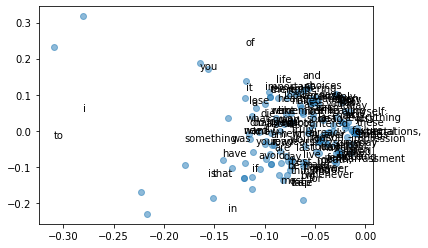

<Figure size 1440x1440 with 0 Axes>

In [45]:
"""
特異値分解後の各単語の先頭2行を抽出し、グラフにプロットする
"""
import matplotlib.pyplot as plt
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id,1]))

plt.scatter(U[:,0], U[:,5], alpha=0.5)
plt.figure(figsize=(20,20))
plt.show()

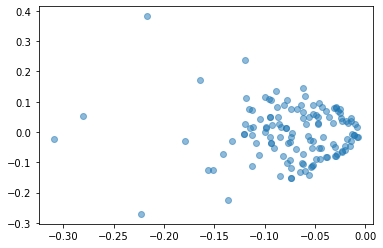

<Figure size 864x864 with 0 Axes>